https://www.tensorflow.org/tutorials/generative/dcgan

In [1]:
import numpy as np
import tensorflow as tf

In [2]:
tf.__version__, tf.config.list_physical_devices('GPU'), tf.test.gpu_device_name()

('2.3.0',
 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')],
 '/device:GPU:0')

#### 准备数据

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
x_data = np.vstack([x_train, x_test])
y_data = np.hstack([y_train, y_test])
x_data.shape, y_data.shape

((70000, 28, 28), (70000,))

In [5]:
import random
from matplotlib import pyplot as plt
%matplotlib inline

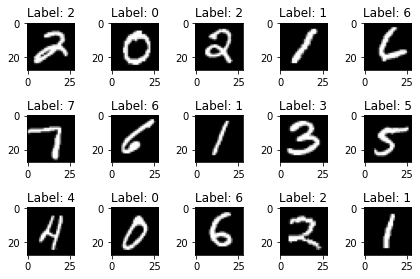

In [6]:
nrows = 3
ncols = 5

plt.subplots(nrows=nrows, ncols=ncols)
plt.tight_layout()

for i in range(1, nrows+1): 
    for j in range(1, ncols+1):
        axi = (i - 1) * ncols + j
        index_rand = random.randint(0, len(x_data)-1)
        image_rand = x_data[index_rand]
        label_rand = y_data[index_rand]
        ax = plt.subplot(nrows, ncols, axi, title=f"Label: {label_rand}", ymargin=2)
        ax.imshow(image_rand, cmap='gray')
plt.show()

#### Teacher

In [7]:
def make_teacher():
    model = tf.keras.Sequential([
        tf.keras.layers.LayerNormalization(axis=(1, 2), input_shape=(28, 28)),
        tf.keras.layers.Reshape((28, 28, 1), input_shape=(28, 28)),

        tf.keras.layers.Conv2D(64, (5, 5), strides=2, padding="same"),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Conv2D(128, (5, 5), strides=2, padding='same'),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1)
        
    ])
    return model

teacher = make_teacher()
teacher.summary()

s_image_index = np.random.randint(low=0, high=len(x_data), size=(3,))
sx_data = x_data[s_image_index]    
    
print(teacher(sx_data))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_normalization (LayerNo (None, 28, 28)            1568      
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

#### Student

In [8]:
def make_student():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(7*7*128, use_bias=False, input_shape=(100,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        
        tf.keras.layers.Reshape((7, 7, 128)),
        tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=2, padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
    
        tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=2, padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        
        tf.keras.layers.Lambda(lambda x: tf.squeeze(x, -1)),
    
    ])
    return model

student = make_student()
student.summary()
thought = np.random.rand(3, 100)
y = student(thought)

y.shape

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              627200    
_________________________________________________________________
batch_normalization (BatchNo (None, 6272)              25088     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        204800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)       

TensorShape([3, 28, 28])

### Born

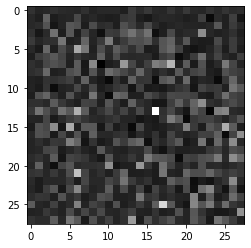

In [12]:
noise = tf.random.normal([1, 100])
generated_image = student(noise, training=False)

plt.imshow(generated_image[0], cmap='gray')


In [13]:
decision = teacher(generated_image)
print (decision)

tf.Tensor([[0.0346415]], shape=(1, 1), dtype=float32)
